<center><a href="https://www.nvidia.com/en-us/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>

# 2. Diffusion Models

In the previous notebook, we learned how to separate noise from an image using a U-Net, but it was not capable of generating believable new images from noise. Diffusion models are much better at generating images from scratch.

The good news, our neural network model will not change much. We will be building off of the U-Net architecture with some slight modifications.

Instead, the big difference is how we use our model. Rather than adding noise to our images all at once, we will be adding a small amount of noise multiple times. We can then use our neural network on a noisy image multiple times to generate a new image like so:

<center><img src="images/rev_diffusion.png" /></center>

#### Learning Objectives

The goals of this notebook are to:
* Construct a forward diffusion variance schedule
* Define the forward diffusion function, `q`
* Update the U-Net architecture to accommodate a timestep, `t`
* Train a model to detect noise added to an image based on the timestep `t`
* Define a reverse diffusion function to emulate `p`
* Attempt to generate articles of clothing (again)

We've moved some of the functions from the previous notebook into a [other_utils.py](utils/other_utils.py) file. We can use it to reload the fashionMNIST dataset:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam

# Visualization tools
import matplotlib.pyplot as plt
from IPython.display import Image

# User defined libraries
from utils import other_utils

IMG_SIZE = 16
IMG_CH = 1
BATCH_SIZE = 128
data, dataloader = other_utils.load_transformed_fashionMNIST(IMG_SIZE, BATCH_SIZE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2.1 Forward Diffusion

Let `T` be the number of times we will add noise to an image. We can use `t` to keep track of the current `timestep`.

In the previous notebook, we used the term `beta` to represent what percentage of the new image was noise compared to the original image. The default was 50% noise and 50% the original image. This time, we will use a `variance schedule`, represented as $\beta_t$, or `B` in code. This will describe how much noise will be added to our image at each timestep `t`.

In section 4 of the paper [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239?ref=assemblyai.com), the authors discuss the art of defining a good schedule. It should be large enough for the model to recognize noise was added (especially since the image may already be noisy), but still as small as possible.

In [2]:
nrows = 10
ncols = 15

T = nrows * ncols
start = 0.0001
end = 0.02
B = torch.linspace(start, end, T).to(device)
B

tensor([1.0000e-04, 2.3356e-04, 3.6711e-04, 5.0067e-04, 6.3423e-04, 7.6779e-04,
        9.0134e-04, 1.0349e-03, 1.1685e-03, 1.3020e-03, 1.4356e-03, 1.5691e-03,
        1.7027e-03, 1.8362e-03, 1.9698e-03, 2.1034e-03, 2.2369e-03, 2.3705e-03,
        2.5040e-03, 2.6376e-03, 2.7711e-03, 2.9047e-03, 3.0383e-03, 3.1718e-03,
        3.3054e-03, 3.4389e-03, 3.5725e-03, 3.7060e-03, 3.8396e-03, 3.9732e-03,
        4.1067e-03, 4.2403e-03, 4.3738e-03, 4.5074e-03, 4.6409e-03, 4.7745e-03,
        4.9081e-03, 5.0416e-03, 5.1752e-03, 5.3087e-03, 5.4423e-03, 5.5758e-03,
        5.7094e-03, 5.8430e-03, 5.9765e-03, 6.1101e-03, 6.2436e-03, 6.3772e-03,
        6.5107e-03, 6.6443e-03, 6.7779e-03, 6.9114e-03, 7.0450e-03, 7.1785e-03,
        7.3121e-03, 7.4456e-03, 7.5792e-03, 7.7128e-03, 7.8463e-03, 7.9799e-03,
        8.1134e-03, 8.2470e-03, 8.3805e-03, 8.5141e-03, 8.6477e-03, 8.7812e-03,
        8.9148e-03, 9.0483e-03, 9.1819e-03, 9.3154e-03, 9.4490e-03, 9.5826e-03,
        9.7161e-03, 9.8497e-03, 9.9832e-

A [Normal Dsitribution](https://mathworld.wolfram.com/NormalDistribution.html) has the following signature:

$\mathcal{N}(x;u,\sigma^2)$ = $\frac{1}{\sigma\sqrt{2\pi}}\mathcal{e}^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^{2}}$

which reads as, "the normal distribution of $x$ with parameters $u$ (the mean) and $\sigma^2$ (the variance). When $\mu$ is 0 amd $\sigma$ is 1, we have a standard normal distribution $\mathcal{N}(x;0,1)$, which has the probability density of the shape below: 

<center><img src="images/normal.png" /></center>

If we are altering our image with noise multiple times accross many timesteps, let's describe $\mathbf{x}_{t}$ as our image at timestep $t$. Then, $\mathbf{x}_{t-1}$ would be the image at the previous timestep and $x_{0}$ would be the original image.

In the previous notebook, we added noise to images using the equation:

$q(\mathbf{x}_{t}|\mathbf{x}_{t-1})=\mathcal{N}(\mathbf{x}_{t};(1-\beta_{t}) \cdot \mathbf{x}_{t-1},\beta_{t}^{2}  \cdot \mathbf{I})$

Where $q$ represents a probability distribution for the [forward diffusion process](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/#forward-diffusion-process) and $q(\mathbf{x}_{t}|\mathbf{x}_{t-1})$ describes the probability distribution for a new, noiser image $\mathbf{x}_{t}$ based on $\mathbf{x}_{t-1}$.

This time, we will alter images with the similar equation:

$q(\mathbf{x}_{t}|\mathbf{x}_{t-1})=\mathcal{N}(\mathbf{x}_{t};\sqrt{1-\beta_{t}} \cdot \mathbf{x}_{t-1},\beta_{t} \cdot \mathbf{I})$

We can sample from this probability distribution by first sampling from a standard normal distribution $\mathcal{N}(x;0,1)$ using [torch.randn_like](https://pytorch.org/docs/stable/generated/torch.randn_like.html):

`noise = torch.randn_like(x_t)`

We can then multiply and add to the noise to sample from `q`:

`x_t = torch.sqrt(1 - B[t]) * x_t + torch.sqrt(B[t]) * noise`

Let's see all of this in practice. Run the code cell below to perform forward diffusion `T` (or `150`) times on the first image of our dataset.

In [ ]:
plt.figure(figsize=(8, 8))
x_0 = data[0][0].to(device)  # Initial image
x_t = x_0  # Set up recursion
xs = []  # Store x_t for each T to see change

for t in range(T):
    noise = torch.randn_like(x_t)
    x_t = torch.sqrt(1 - B[t]) * x_t + torch.sqrt(B[t]) * noise  # sample from q(x_t|x_t-1)
    img = torch.squeeze(x_t).cpu()
    xs.append(img)
    ax = plt.subplot(nrows, ncols, t + 1)
    ax.axis("off")
    plt.imshow(img)
plt.savefig("forward_diffusion.png", bbox_inches="tight")

Or in animated form:

MovieWriter ffmpeg unavailable; using Pillow instead.


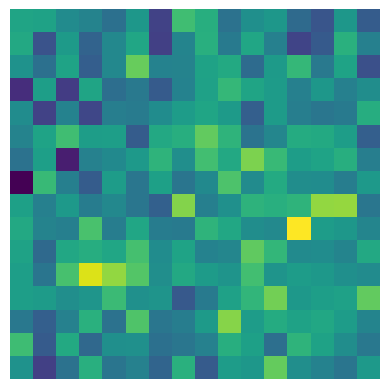

In [4]:
gif_name = "forward_diffusion.gif"
other_utils.save_animation(xs, gif_name)

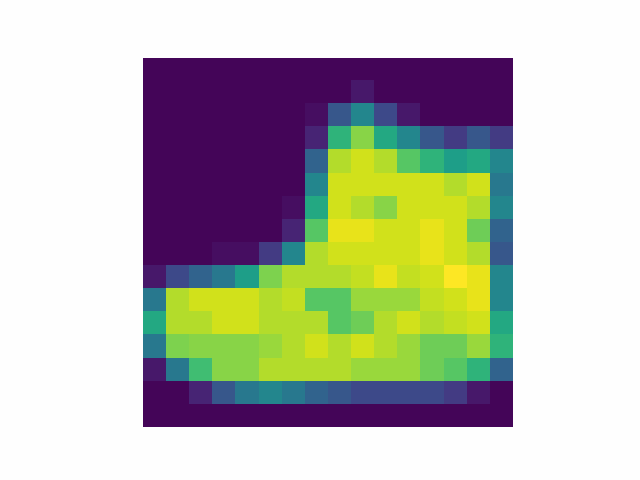

In [5]:
Image(open(gif_name,'rb').read())

## 2.2 Skipping Ahead

We could take each image of our dataset and add noise to them `T` times to create `T` more new images, but do we need to? 

Thanks to the power of recursion, we can estimate what $x_t$ would look like given our beta schedule $\beta_t$. A full breakdown of the math can be found in [Lilian Weng's Blog](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/#speed-up-diffusion-model-sampling).
Let's bring back `a`lpha, which is the compliment of $\beta$. We can define $\alpha_t$ as $1 - \beta_t$, and we can define $\bar{\alpha}_t$ as the [cumulative product](https://pytorch.org/docs/stable/generated/torch.cumprod.html) of $\alpha_t$.

For example, $\bar{\alpha}_3 = \alpha_0 \cdot \alpha_1 \cdot \alpha_2 \cdot \alpha_3$

Because of the bar symbol, let's call $\bar{\alpha}_t$ `a_bar`. Our new noisy image distribution becomes:

$q(\mathbf{x}_{t}|\mathbf{x}_{0})=\mathcal{N}(\mathbf{x}_{t};\sqrt{\bar{\alpha}_{t}} \cdot x_{0},(1 - \bar{\alpha}_t) \cdot \mathbf{I})$

Which translates to code as:

`x_t = sqrt_a_bar_t * x_0 + sqrt_one_minus_a_bar_t * noise`

We are now no longer dependent on $\mathbf{x}_{t-1}$ and can estimate $\mathbf{x}_t$ from $x_0$. Let's define these variables in code:

In [6]:
a = 1. - B
a_bar = torch.cumprod(a, dim=0)
sqrt_a_bar = torch.sqrt(a_bar)  # Mean Coefficient
sqrt_one_minus_a_bar = torch.sqrt(1 - a_bar) # St. Dev. Coefficient

We have all the pieces, let's code our forward diffusion sampling function `q`:

$q(\mathbf{x}_{t}|\mathbf{x}_{0})=\mathcal{N}(\mathbf{x}_{t};\sqrt{\bar{\alpha}_{t}} \cdot \mathbf{x}_{0},(1 - \bar{\alpha}_t) \cdot \mathbf{I})$

Currently, `sqrt_a_bar` and `sqrt_one_minus_a_bar` only have one dimension, and if we index into them with `t`, they will each only have one value. If we want to multiply this value with each of the pixel values in our images, we will need to match the number of dimensions in order to [broadcast](https://numpy.org/doc/stable/user/basics.broadcasting.html).

<center><img src="images/broadcasting.png" width="60%" /></center>

We can add an extra dimension by indexing with `None`. This is a PyTorch shortcut to add an extra dimension to the resulting tensor. For reference, a batch of images has the dimensions: `batch dimension x image channels x image height x image width`.

In [7]:
def q(x_0, t):
    """
    Samples a new image from q
    Returns the noise applied to an image at timestep t
    x_0: the original image
    t: timestep
    """
    t = t.int()
    noise = torch.randn_like(x_0)
    sqrt_a_bar_t = sqrt_a_bar[t, None, None, None]
    sqrt_one_minus_a_bar_t = sqrt_one_minus_a_bar[t, None, None, None]

    x_t = sqrt_a_bar_t * x_0 + sqrt_one_minus_a_bar_t * noise
    return x_t, noise

Let's test out this new method compared to our old method of recursively generating the images.

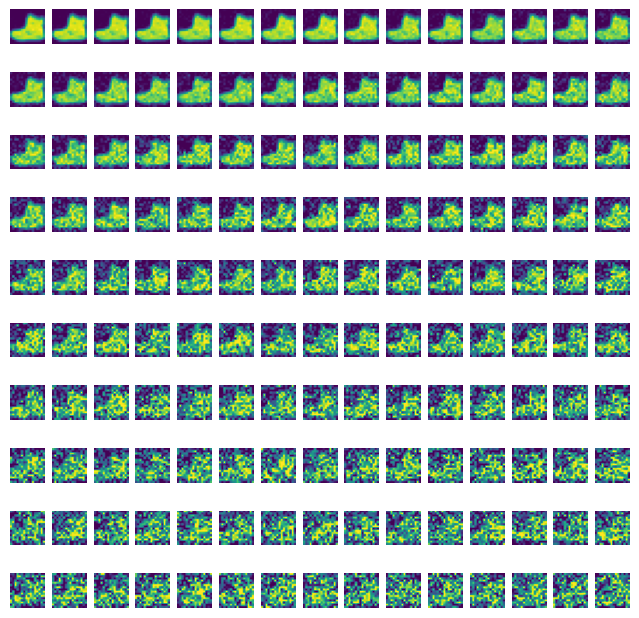

In [8]:
plt.figure(figsize=(8, 8))
xs = []

for t in range(T):
    t_tenser = torch.Tensor([t]).type(torch.int64)
    x_t, _ = q(x_0, t_tenser)
    img = torch.squeeze(x_t).cpu()
    xs.append(img)
    ax = plt.subplot(nrows, ncols, t + 1)
    ax.axis('off')
    other_utils.show_tensor_image(x_t)
plt.savefig("forward_diffusion_skip.png", bbox_inches='tight')

In [ ]:
gif_name = "forward_diffusion_skip.gif"
other_utils.save_animation(xs, gif_name)

In [ ]:
Image(open(gif_name,'rb').read())

Compared to the previous technique, can you see any differences? When noise is added sequentially, there is a smaller difference between the images of consecutive timesteps. Despite this, the neural network will do a good job separating the noise from the original image in the reverse diffusion process.

## 2.3 Predicting Noise

The architecture for our neural network will mostly be the same as before. However, because the amount of noise added changes with each time step, we will need a way to tell the model which time step our input image is at.

To do that, we can create an embedding block like the one below.
* `input_dim` is the number of dimensions of the value we'd like to embed. We'll be embedding `t`, which is a one-dimensional scalar.
* `emb_dim` is the number of dimensions we would like to convert our input value into by using a [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layer.
* [UnFlatten](https://pytorch.org/docs/stable/generated/torch.nn.Unflatten.html) is used to reshape a vector into a multidimensional space. Since we'll be adding the result of this embedding to a multidimensional feature map, we will add a few extra dimensions similar to how we expanded the dimension in the `q` function above.

In [9]:
class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super().__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.ReLU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1))
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, input):
        input = input.view(-1, self.input_dim)
        return self.model(input)

We will add this time embedding block to each `UpBlock` of our U-Net, resulting in the following architecture.

<center><img src="images/time_nn.png" width="80%" /></center>

**TODO**: Our `DownBlock` is the same as before. Using the above image as a reference, can you replace the `FIXME`s with the correct variable? Each `FIXME` can be one of:
* `in_chs`
* `out_chs`
* `kernel_size`
* `stride`
* `padding`

Click the `...` below for the correct answer.

In [10]:
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs):
        kernel_size = 3
        stride = 1
        padding = 1

        super().__init__()
        layers = [
            nn.Conv2d(FIXME, FIXME, FIXME, FIXME, FIXME),
            nn.BatchNorm2d(FIXME),
            nn.ReLU(),
            nn.Conv2d(FIXME, FIXME, FIXME, FIXME, FIXME),
            nn.BatchNorm2d(FIXME),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [11]:
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs):
        kernel_size = 3
        stride = 1
        padding = 1

        super().__init__()
        layers = [
            nn.Conv2d(in_chs, out_chs, kernel_size, stride, padding),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(),
            nn.Conv2d(out_chs, out_chs, kernel_size, stride, padding),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

The `UpBlock` follows a similar logic, but instead uses [Transposed Convolution](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html).

**TODO**: Can you replace the `FIXME`s with the correct variable? Each `FIXME` can be one of:
* `in_chs`
* `out_chs`
* `kernel_size`
* `stride`
* `padding`
* `strideT`
* `out_paddingT`
* `x`
* `skip`

Click the `...` below for the correct answer.

In [12]:
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs):
        # Convolution variables
        kernel_size = 3
        stride = 1
        padding = 1

        # Transpose variables
        strideT = 2
        out_paddingT = 1

        super().__init__()
        # 2 * in_chs for concatenated skip connection
        layers = [
            nn.ConvTranspose2d(FIXME, FIXME, FIXME, FIXME, FIXME, FIXME),
            nn.BatchNorm2d(FIXME),
            nn.ReLU(),
            nn.Conv2d(FIXME, FIXME, FIXME, FIXME, FIXME),
            nn.BatchNorm2d(FIXME),
            nn.ReLU()
        ]
        self.model = nn.Sequential(*layers)
    
    def forward(self, x, skip):
        x = torch.cat((FIXME, FIXME), 1)
        x = self.model(FIXME)
        return x

In [13]:
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs):
        # Convolution variables
        kernel_size = 3
        stride = 1
        padding = 1

        # Transpose variables
        strideT = 2
        out_paddingT = 1

        super().__init__()
        # 2 * in_chs for concatenated skip connection
        layers = [
            nn.ConvTranspose2d(2 * in_chs, out_chs, kernel_size, strideT, padding, out_paddingT),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(),
            nn.Conv2d(out_chs, out_chs, kernel_size, stride, padding),
            nn.BatchNorm2d(out_chs),
            nn.ReLU()
        ]
        self.model = nn.Sequential(*layers)
    
    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

The final U-Net is similar to what we used in the first lab. The difference is we now have a time embedding connected to our `UpBlock`s.

**TODO**: While the time embeddings have been integrated into the model, there are still a number of `FIXME`s to replace. This time, the image channels, up channels, and down channels need fixing. Can you work down and up the U-Net to set the correct number of channels at each step?

Each `FIXME` could be:
* `img_chs`
* A value in `down_chs`
* A value in `up_chs`

Click the `...` below for the correct answer.

In [14]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        img_chs = IMG_CH
        down_chs = (16, 32, 64)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = IMG_SIZE // 4 # 2 ** (len(down_chs) - 1)
        t_dim = 1 # New

        # Inital convolution
        self.down0 = nn.Sequential(
            nn.Conv2d(FIXME, down_chs[0], 3, padding=1),
            nn.BatchNorm2d(FIXME),
            nn.ReLU()
        )

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1])
        self.down2 = DownBlock(FIXME, FIXME)
        self.to_vec = nn.Sequential(nn.Flatten(), nn.ReLU())
        
        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(FIXME*latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], FIXME),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2]*latent_image_size**2),
            nn.ReLU()
        )
        self.temb_1 = EmbedBlock(t_dim, up_chs[0]) # New
        self.temb_2 = EmbedBlock(t_dim, up_chs[1]) # New
        
        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (FIXME, latent_image_size, latent_image_size)),
            nn.Conv2d(FIXME, up_chs[0], 3, padding=1),
            nn.BatchNorm2d(up_chs[0]),
            nn.ReLU(),
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1])
        self.up2 = UpBlock(FIXME, FIXME)

        # Match output channels
        self.out = nn.Sequential(
            nn.Conv2d(FIXME, FIXME, 3, 1, 1),
            nn.BatchNorm2d(up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_chs, 3, 1, 1)
        )

    def forward(self, x, t):
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)
        
        latent_vec = self.dense_emb(latent_vec)
        # New
        t = t.float() / T  # Convert from [0, T] to [0, 1]
        temb_1 = self.temb_1(t)
        temb_2 = self.temb_2(t)

        up0 = self.up0(latent_vec)
        up1 = self.up1(up0+temb_1, down2)
        up2 = self.up2(up1+temb_2, down1)
        return self.out(up2)

In [15]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        img_chs = IMG_CH
        down_chs = (16, 32, 64)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = IMG_SIZE // 4 # 2 ** (len(down_chs) - 1)
        t_dim = 1 # New

        # Inital convolution
        self.down0 = nn.Sequential(
            nn.Conv2d(img_chs, down_chs[0], 3, padding=1),
            nn.BatchNorm2d(down_chs[0]),
            nn.ReLU()
        )

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1])
        self.down2 = DownBlock(down_chs[1], down_chs[2])
        self.to_vec = nn.Sequential(nn.Flatten(), nn.ReLU())
        
        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2]*latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2]*latent_image_size**2),
            nn.ReLU()
        )
        self.temb_1 = EmbedBlock(t_dim, up_chs[0])  # New
        self.temb_2 = EmbedBlock(t_dim, up_chs[1])  # New
        
        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            nn.Conv2d(up_chs[0], up_chs[0], 3, padding=1),
            nn.BatchNorm2d(up_chs[0]),
            nn.ReLU(),
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1])
        self.up2 = UpBlock(up_chs[1], up_chs[2])

        # Match output channels
        self.out = nn.Sequential(
            nn.Conv2d(up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.BatchNorm2d(up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_chs, 3, 1, 1)
        )

    def forward(self, x, t):
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)
        
        # New
        t = t.float() / T  # Convert from [0, T] to [0, 1]
        latent_vec = self.dense_emb(latent_vec)
        temb_1 = self.temb_1(t)
        temb_2 = self.temb_2(t)

        up0 = self.up0(latent_vec)
        up1 = self.up1(up0+temb_1, down2)
        up2 = self.up2(up1+temb_2, down1)
        return self.out(up2)

In [16]:
model = UNet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model = torch.compile(UNet().to(device))

Num params:  240385


### 2.3.1 The Loss Function

In the first notebook, we used a [Mean Squared Error](https://developers.google.com/machine-learning/glossary#mean-squared-error-mse) loss function comparing the original image and the predicted original image based on noise.

This time, we'll compare the real noise that was added to the image and the predicted noise. Lilian Weng goes into the math in this [blog post](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/#parameterization-of-l_t-for-training-loss). Originally, the loss function was based on the [Evidence Lower Bound (ELBO)](https://en.wikipedia.org/wiki/Evidence_lower_bound) [Log-Likelihood](https://mathworld.wolfram.com/Log-LikelihoodFunction.html), but it was found in the [Denoising Diffusion Probabilistic Models Paper](https://arxiv.org/abs/2006.11239) that the Mean Squared Error between the predicted noise and true noise was better in practice. If curious, Lilian Weng walks through the derivation [here](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/#reverse-diffusion-process).

In [17]:
def get_loss(model, x_0, t):
    x_noisy, noise = q(x_0, t)
    noise_pred = model(x_noisy, t)
    return F.mse_loss(noise, noise_pred)

## 2.4 Reverse Diffusion

We now have a model that predicts the noise added to an image at timestep `t`, but generating images is not as easy as repeatedly subtracting and adding noise. The `q` function can be reversed such that we generate $\mathbf{x}_{t-1}$ from $\mathbf{x}_t$.

$q(\mathbf{x}_{t-1}|\mathbf{x}_{t},\mathbf{x}_{0}) = \mathcal{N}(\mathbf{x}_{t-1};{\mathbf{\tilde{\mu}}}(\mathbf{x_t},\mathbf{x_0}), \tilde{\beta}_t \cdot \mathbf{I})$

**Note**: $\tilde{\beta}_t$ was originally calculated to be $\frac{1-\overline{a}_{t-1}}{1-\overline{a}_{t}}\beta_t$, but in practice, using only $\beta_t$ is more effective.

Using [Bayes' Theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem), we can derive an equation for the model_mean `u_t` at timestep `t`.

${\mathbf{\tilde{\mu}}}_t = \frac{1}{\sqrt{\alpha_t}}(\mathbf{x_t}-\frac{1-\alpha_t}{\sqrt{1-\overline{\alpha_t}}}\mathbf{\epsilon}_t)$

The image $\mathbf{x}_{t-1}$ can be estimated by ${\mathbf{\tilde{\mu}}}_t + \tilde{\beta}_t \cdot \mathbf{I}$, so we'll use this equation to generate sample images recursively until we reach `t == 0`. Let's see what this means in code. First, we will precompute the values needed to calculate `u_t`.

In [18]:
sqrt_a_inv = torch.sqrt(1 / a)
pred_noise_coeff = (1 - a) / torch.sqrt(1 - a_bar)

Next, we will create the reverse diffusion function, `reverse_q`.

In [19]:
@torch.no_grad()
def reverse_q(x_t, t, e_t):
    t = torch.squeeze(t[0].int())  # All t values should be the same
    pred_noise_coeff_t = pred_noise_coeff[t]
    sqrt_a_inv_t = sqrt_a_inv[t]
    u_t = sqrt_a_inv_t * (x_t - pred_noise_coeff_t * e_t)
    if t == 0:
        return u_t  # Reverse diffusion complete!
    else:
        B_t = B[t-1]
        new_noise = torch.randn_like(x_t)
        return u_t + torch.sqrt(B_t) * new_noise

Let's create a function to iteratively remove noise from an image until it is noise free. Let's also display these images so we can see how the model is improving.

In [20]:
@torch.no_grad()
def sample_images(ncols, figsize=(8,8)):
    plt.figure(figsize=figsize)
    plt.axis("off")
    hidden_rows = T / ncols

    # Noise to generate images from
    x_t = torch.randn((1, IMG_CH, IMG_SIZE, IMG_SIZE), device=device)

    # Go from T to 0 removing and adding noise until t = 0
    plot_number = 1
    for i in range(0, T)[::-1]:
        t = torch.full((1,), i, device=device)
        e_t = model(x_t, t)  # Predicted noise
        x_t = reverse_q(x_t, t, e_t)
        if i % hidden_rows == 0:
            ax = plt.subplot(1, ncols+1, plot_number)
            ax.axis('off')
            other_utils.show_tensor_image(x_t.detach().cpu())
            plot_number += 1
    plt.show()

Time to train the model! How about it? Does it look like the model is learning?

Epoch 0 | Step 000 | Loss: 1.211681842803955 


/tmp/ipykernel_2388/3817596156.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1, ncols+1, plot_number)


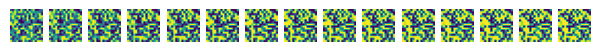

Epoch 0 | Step 100 | Loss: 0.42293423414230347 


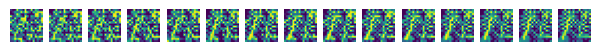

Epoch 0 | Step 200 | Loss: 0.2776068449020386 


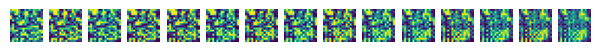

Epoch 0 | Step 300 | Loss: 0.28333210945129395 


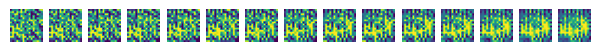

Epoch 0 | Step 400 | Loss: 0.2505013048648834 


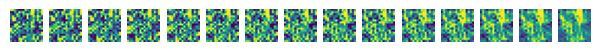

Epoch 0 | Step 500 | Loss: 0.21368061006069183 


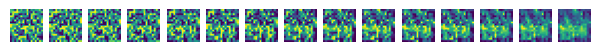

Epoch 1 | Step 000 | Loss: 0.21662290394306183 


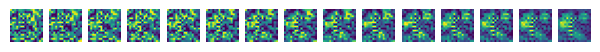

Epoch 1 | Step 100 | Loss: 0.19410455226898193 


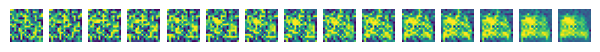

Epoch 1 | Step 200 | Loss: 0.18438300490379333 


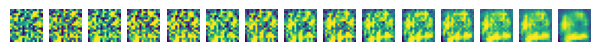

Epoch 1 | Step 300 | Loss: 0.21097609400749207 


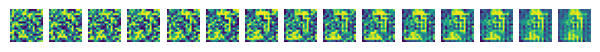

Epoch 1 | Step 400 | Loss: 0.18573808670043945 


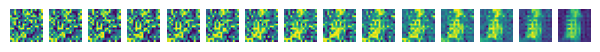

Epoch 1 | Step 500 | Loss: 0.1671019345521927 


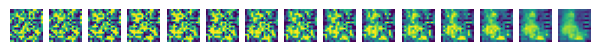

Epoch 2 | Step 000 | Loss: 0.17685911059379578 


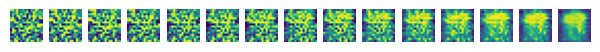

Epoch 2 | Step 100 | Loss: 0.15911215543746948 


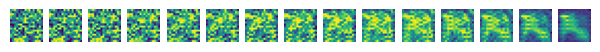

Epoch 2 | Step 200 | Loss: 0.16640068590641022 


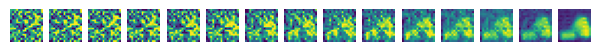

Epoch 2 | Step 300 | Loss: 0.17968809604644775 


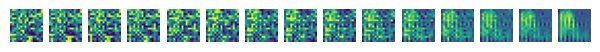

Epoch 2 | Step 400 | Loss: 0.17599321901798248 


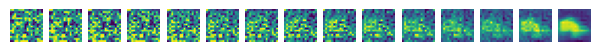

Epoch 2 | Step 500 | Loss: 0.16576236486434937 


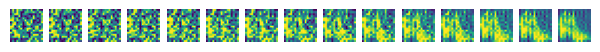

Final sample:


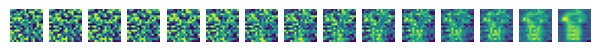

In [21]:
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 3
ncols = 15  # Should evenly divide T

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device)
        x = batch[0].to(device)
        loss = get_loss(model, x, t)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0 and step % 100 == 0:
            print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()} ")
            sample_images(ncols)
print("Final sample:")
sample_images(ncols)

If you squint your eyes, can you make out what the model is generating?

/tmp/ipykernel_2388/3817596156.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1, ncols+1, plot_number)


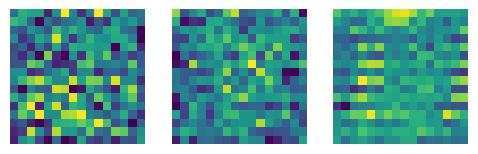

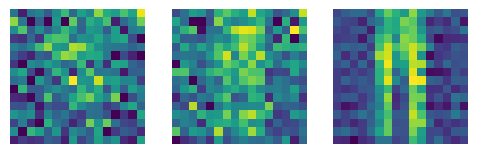

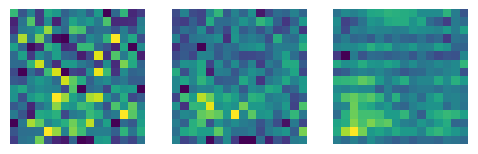

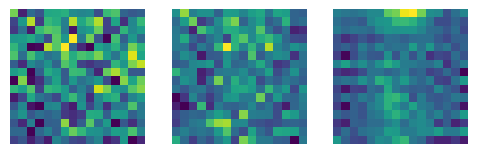

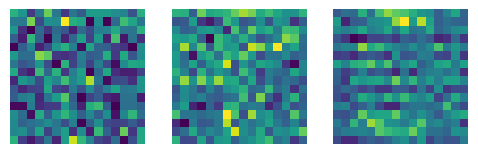

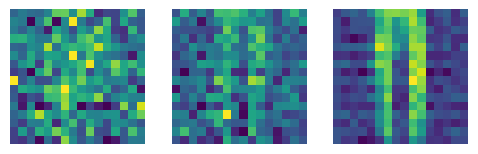

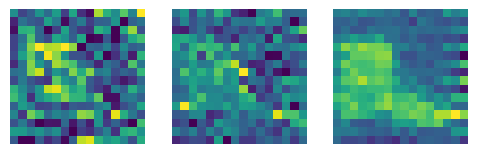

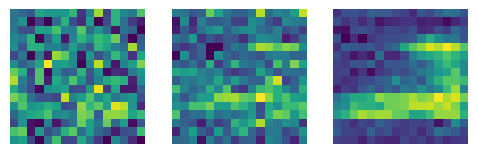

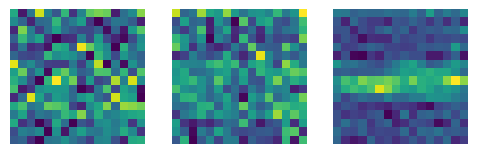

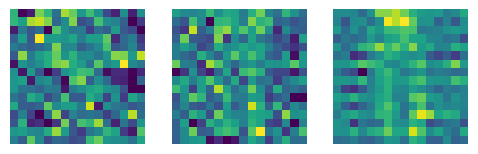

In [22]:
model.eval()
figsize=(8,8) # Change me
ncols = 3 # Should evenly divide T
for _ in range(10):
    sample_images(ncols, figsize=figsize)

## 2.5 Next

The model is learning ... something. It looks a little pixelated. Why would that be? Continue to the next notebook to find out more!

In [23]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<center><a href="https://www.nvidia.com/en-us/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>